In [1]:
%load_ext autoreload
%autoreload 2

import roboscientist
from roboscientist import datasets
from roboscientist.datasets import equations_settings
import sympy as snp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from roboscientist.datasets.equations_utils import expr_to_tree

## Generate equation

In [2]:
np.random.seed(1389)
equation = datasets.generate_random_equation(nodes=15, n_variables=3, max_degree=2)
equation

Add(Mul(Symbol('x1'), Add(Symbol('x0'), Integer(1)), sin(sin(Add(cos(Symbol('x0')), Integer(1))))), cos(Integer(1)))

In [3]:
equation.expr

x1*(x0 + 1)*sin(sin(cos(x0) + 1)) + cos(1)

In [4]:
X = np.random.randn(1000, len(equation.variables))
y = equation(X)

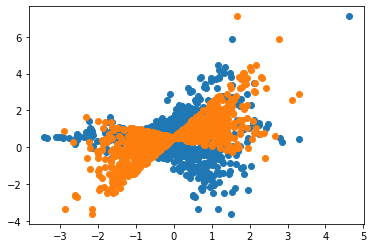

In [5]:
plt.scatter(X[:, 0], y); plt.scatter(X[:, 1], y);

In [6]:
print(equation.postfix, equation.variables)

(['x1', 1.0, 'x0', 'Add', 1.0, 'x0', 'cos', 'Add', 'sin', 'sin', 'Mul', 1.0, 'cos', 'Add'], [0, 0, 0, 2, 0, 0, 1, 2, 1, 1, 3, 0, 1, 2]) [x0, x1]


In [7]:
D, _ = expr_to_tree(equation._expr)

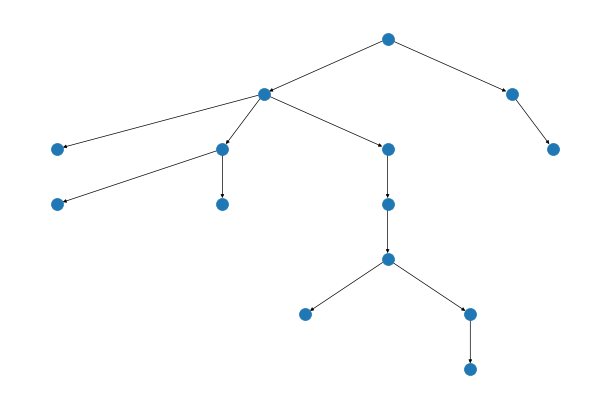

In [8]:
plt.figure(figsize=(12, 8), dpi=50)
pos = graphviz_layout(D, prog="dot")
nx.draw(D, pos)
plt.show()

## Brute force

In [9]:
from roboscientist.models import brute_force
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [10]:
from scipy.optimize import minimize
from functools import partial

def _optimize_constants(constants, X, y, equation):
    y_hat = np.real(equation.func(X, constants))
    loss = ((y_hat - y)**2).mean()
    return np.abs(loss)

def optimize_constants(candidate_equation, X, y, n_restarts):
    """
    Optimize all available constants in the equation
    """
    # is has constants
    best_loss = 1e10
    best_constants = None
    err = None
    
    if candidate_equation.constants:
        for restart in range(n_restarts):
            try:
                res = minimize(
                    partial(_optimize_constants, X=X + 0j, y=y, equation=candidate_equation), 
                    np.random.uniform(low=1, high=2, size=len(candidate_equation.constants))
                )
                fun = res.fun
                consts = res.x
                if res.fun < best_loss:
                    best_loss = res.fun
                    best_constants = res.x
                    
            except ValueError:
                pass
        if best_constants is None:
            return None, None, "Err"
        else:
            candidate_equation = candidate_equation.subs(best_constants)
    else:
        y_hat = np.real(candidate_equation.func(X + 0j))
        best_loss = ((y_hat - y)**2).mean()
        if best_loss is None:
            return None, None, "Err"
        
    return best_loss, candidate_equation, None

In [11]:
from tqdm import tqdm

n = 0
best_loss = 1e9
best_candidate_equation = None
for candidate_equation in tqdm(brute_force.brute_force_solver(6, n_symbols=2)):
    loss, candidate_equation, err = optimize_constants(candidate_equation, X, y, n_restarts=5)
    if err:
        continue
    else:
        if loss < best_loss:
            best_loss = loss
            best_candidate_equation = candidate_equation
            print(best_loss, best_candidate_equation)

12it [00:00, 97.65it/s]

1.8207319312733627 sin(x0)
1.0610366987226418 0.527171003476815
1.0610366987226416 0.527171004141414


68it [00:01, 36.57it/s]

0.7596067316861028 x1 + cos(x0)


78it [00:01, 39.95it/s]

0.7590637590943696 sqrt(x0) + x1


110it [00:02, 45.15it/s]

0.5687858967533196 sqrt(x0)*x1


903it [00:24, 33.85it/s]

0.46310910335801636 1.53223527797665*sqrt(x0)*x1


1161it [00:30, 38.42it/s]


In [12]:
best_candidate_equation.expr

1.53223527797665*sqrt(x0)*x1

## Plot residuals and QQ-plot

In [13]:
y_hat = np.real(best_candidate_equation(X + 0j))

residuals = y_hat - y

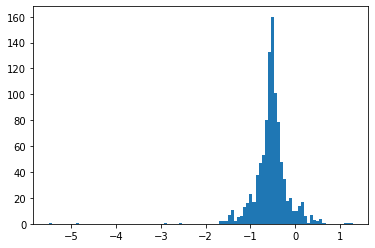

In [14]:
plt.hist(residuals, bins=100);

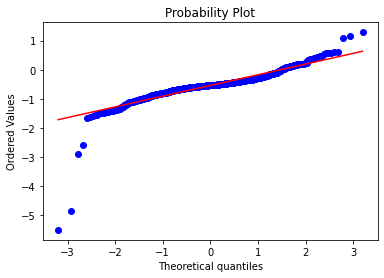

In [15]:
import scipy.stats as stats

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

## Plot residuals and QQ-plot on test dataset

In [16]:
X_test = np.random.randn(10000, len(equation.variables))
y_test = equation(X_test)

In [17]:
y_test_hat = np.real(best_candidate_equation(X_test + 0j))

residuals = y_test_hat - y_test

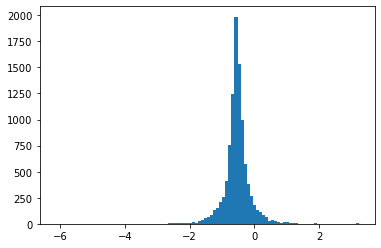

In [18]:
plt.hist(residuals, bins=100);

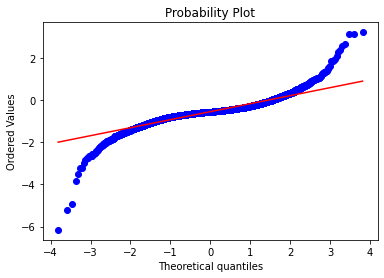

In [19]:
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

## Let's also take a look on imag part

In [25]:
y_test_hat_imag = np.imag(best_candidate_equation(X_test + 0j))

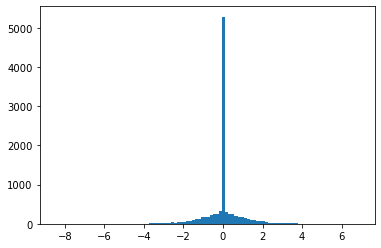

In [26]:
plt.hist(y_test_hat_imag, bins=100);

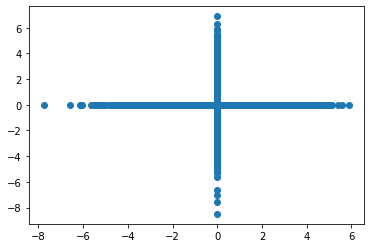

In [27]:
plt.scatter(y_test_hat, y_test_hat_imag)

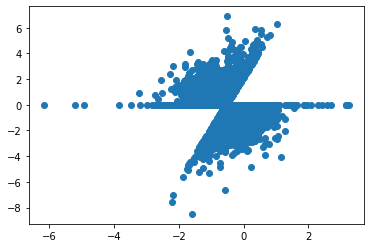

In [28]:
plt.scatter(residuals, y_test_hat_imag)